# Using the ClusterFinder

In [1]:
#add the aare build folder to sys.path to make it visible to python
import sys
sys.path.append('/home/l_msdetect/erik/aare/build')

#Our normal python imports
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import boost_histogram as bh
import time

#Directly import what we need from aare
from aare import File, ClusterFinder, ClusterFile

base = Path('/mnt/sls_det_storage/matterhorn_data/aare_test_data/')

### Read initial pedestal

- First step is to set up the pedestal
- Note! this particular sensor has some radiation damage

In [2]:
#In this example we set up the pedestal using the beginning of the file
#Better would of course be a dedicated dark measurement
f = File(base/'Moench03new/cu_half_speed_master_4.json')

n_frames_pd = 1000
cluster_size = (3,3)
image_size = (f.rows, f.cols)

#Read n_frames_pd from f and use them to calculate the 
#initial pedestal
t0 = time.perf_counter()
cf = ClusterFinder(image_size, cluster_size)
for i in range(n_frames_pd):
    cf.push_pedestal_frame(f.read_frame())
elapsed_t = time.perf_counter()-t0
print(f'Pedestal took: {elapsed_t:.3f}s')

Pedestal took: 0.293s


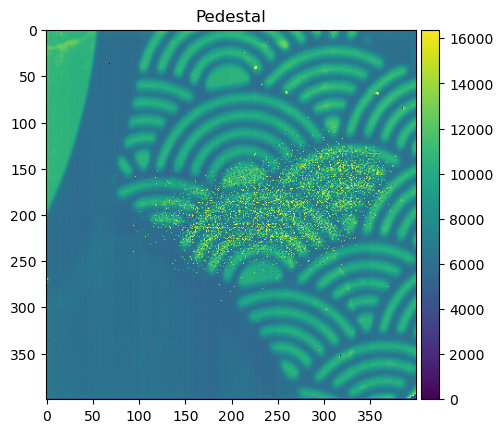

In [3]:
#plot the pedestal including colorbar
fig, ax = plt.subplots()
im = ax.imshow(cf.pedestal())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title('Pedestal');

### Run clustering on N frames

- Now we use the next N frames to find clusters

In [4]:
N = 500
t0 = time.perf_counter()
hist1 = bh.Histogram(bh.axis.Regular(40, -2, 4000))

#Not needed, just here for reproducibility when executing the cell over and over
f.seek(n_frames_pd) 

#Read N frames from the file
t0 = time.perf_counter()
data = f.read_n(N)
t_elapsed = time.perf_counter()-t0
print(f'Reading {N} frames took {t_elapsed:.3f}s {N/t_elapsed:.0f} FPS, {f.bytes_per_frame*N/1024**2:.3f} GB/s')

#Run clustering on all frames in data
t0 = time.perf_counter()
for frame in data:
    cf.find_clusters(frame)
t_elapsed = time.perf_counter()-t0
print(f'Clustering {N} frames took {t_elapsed:.2f}s  {N/t_elapsed:.0f} FPS')

#Fill a boost-histogram with the sum of each cluster
t0 = time.perf_counter()
clusters = cf.steal_clusters()
hist1.fill(clusters.sum())
t_elapsed = time.perf_counter()-t0
print(f'Filling histogram with the sum of {clusters.size} clusters took: {t_elapsed:.3f}s, {clusters.size/t_elapsed:.3g} clust/s')
print(f'Average number of clusters per frame {clusters.size/N:.3f}')

Reading 500 frames took 0.026s 19584 FPS, 152.588 GB/s
Clustering 500 frames took 2.66s  188 FPS
Filling histogram with the sum of 640280 clusters took: 0.007s, 9.68e+07 clust/s
Average number of clusters per frame 1280.560


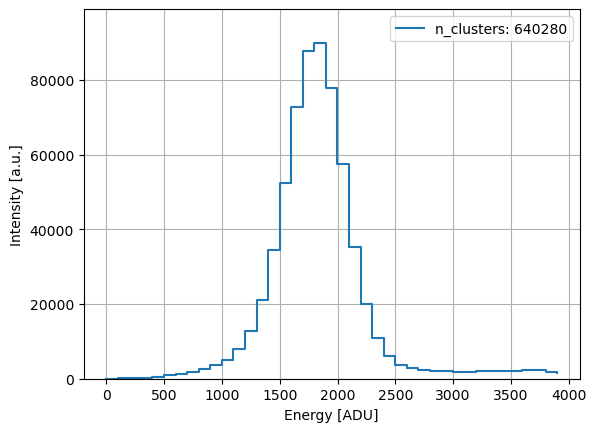

In [5]:
#plot the histogram
fig, ax = plt.subplots()
ax.step(hist1.axes[0].edges[:-1], hist1.values(), where="post", label = f'n_clusters: {clusters.size}');
ax.set_xlabel('Energy [ADU]')
ax.set_ylabel('Intensity [a.u.]')
ax.legend()
ax.set_ylim(0, hist1.values().max()*1.1)
ax.grid()

## Writing ClusterFiles from python

In [6]:
#Not needed, just here for reproducibility when executing the cell over and over
f.seek(n_frames_pd) 
n_frames = 5

with ClusterFile(base/'Moench03new/test.clust', mode = 'w') as cluster_file:
    for i in range(n_frames):
        frame_number = f.frame_number()
        cf.find_clusters(f.read_frame())
        clusters = cf.steal_clusters()
        print(f'Found {clusters.size} clusters in frame {frame_number}')
        cluster_file.write_frame(frame_number, clusters)


Found 1316 clusters in frame 23377
Found 1255 clusters in frame 23378
Found 1317 clusters in frame 23379
Found 1313 clusters in frame 23380
Found 1290 clusters in frame 23381


## Read the clusters back to double check

Read 1316 clusters from frame 23377
Read 1255 clusters from frame 23378
Read 1317 clusters from frame 23379
Read 1313 clusters from frame 23380
Read 1290 clusters from frame 23381


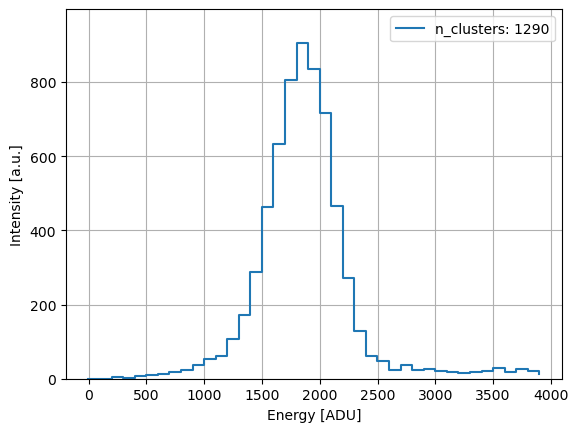

In [7]:
hist1 = bh.Histogram(bh.axis.Regular(40, -2, 4000))

with ClusterFile(base/'Moench03new/test.clust') as cluster_file:
    #Not possible to know the number of frames without 
    #looping on the old cluster file
    for i in range(n_frames): 
        frame_number, clusters = cluster_file.read_frame()
        print(f'Read {clusters.size} clusters from frame {frame_number}')
        hist1.fill(clusters['data'].sum(axis = 1))
        
fig, ax = plt.subplots()
ax.step(hist1.axes[0].edges[:-1], hist1.values(), where="post", label = f'n_clusters: {clusters.size}');
ax.set_xlabel('Energy [ADU]')
ax.set_ylabel('Intensity [a.u.]');
ax.legend()
ax.set_ylim(0, hist1.values().max()*1.1)
ax.grid()

## Using variable sized clusters

In [8]:
# N= 500
# f.seek(0)
# pd = f.read_n(1000).mean(axis = 0)

# cf = VarClusterFinder((400,400),50)
# f.seek(0)

# t0 = time.perf_counter()
# hist1 = bh.Histogram(bh.axis.Regular(40, -2, 4000))

# data = f.read_n(N)
# t0 = time.perf_counter()
# for frame in data:
#     cf.find_clusters(frame-pd)
# elapsed_t = time.perf_counter()-t0
# print(f'Clustering {N} frames took {elapsed_t:.2f}s, {N/elapsed_t:.0f} FPS')

# clusters = cf.steal_hits()
# hist1.fill(clusters['energy']);


In [9]:
# fig, ax = plt.subplots()
# ax.step(hist1.axes[0].edges[:-1], hist1.values(), where="post");
# ax.set_ylim(0,50000)